In [1]:
# Importation des bibliothèques
import numpy as np        # Manipulation de tableaux numériques
import pandas as pd       # Analyse et traitement de données
import matplotlib.pyplot as plt  # Visualisation de données
from pathlib import Path  # pour parcourir tous les fichiers dans le dossier.
from lxml import etree #lecture et analyse de fichier .TCX
import folium
from IPython.display import IFrame
from folium.plugins import HeatMap
from dataclasses import dataclass
import gpxpy




Hello World
Tableau NumPy : [1 2 3 4]
DataFrame Pandas :
   Colonne1  Colonne2
0         1         4
1         2         5
2         3         6


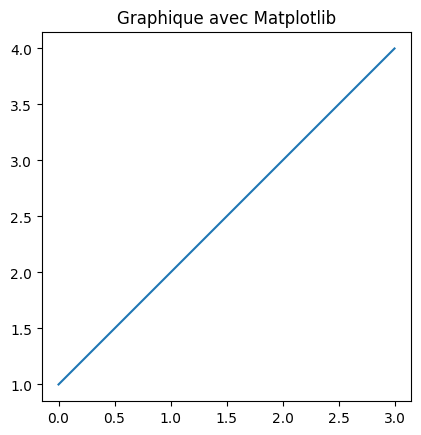

In [6]:
print('Hello World')
# Exemple d'utilisation
data = np.array([1, 2, 3, 4])
print(f"Tableau NumPy : {data}")

df = pd.DataFrame({'Colonne1': [1, 2, 3], 'Colonne2': [4, 5, 6]})
print(f"DataFrame Pandas :\n{df}")

plt.plot(data)
plt.axis('scaled')# Ajuste automatiquement pour conserver les proportions
plt.title("Graphique avec Matplotlib")
plt.show()

In [101]:
# Chemin vers le dossier contenant les fichiers TCX
tcx_folder = Path(r"C:\Users\shumb\OneDrive\Documents\Visual Studio Code\Running Datas\TCX")

# Liste tous les fichiers .tcx dans le dossier
tcx_files = list(tcx_folder.glob("*.tcx"))

print(f"Nombre de fichiers TCX trouvés : {len(tcx_files)}")
print(f"Liste des fichiers TCX : {[file.name for file in tcx_files]}")
# Namespace pour les fichiers TCX
ns = {
    'tcx': 'http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2',
    'ns3': 'http://www.garmin.com/xmlschemas/ActivityExtension/v2'
}

Nombre de fichiers TCX trouvés : 14
Liste des fichiers TCX : ['activity_17482399352.tcx', 'activity_17490289008.tcx', 'activity_17507109341.tcx', 'activity_17512456424.tcx', 'activity_17522554619.tcx', 'activity_17535799744.tcx', 'activity_17550087476.tcx', 'activity_17556631216.tcx', 'activity_17556631939.tcx', 'activity_17649066143.tcx', 'activity_17665683882.tcx', 'activity_17686792876.tcx', 'activity_17700789297.tcx', 'activity_17715922870.tcx']


In [132]:
#Ajouter les fichiers dans un DataFrame avec pandas : Une fois les données extraites, vous pouvez les stocker dans un DataFrame pour une analyse plus facile.

data = []  # Liste pour stocker les données

for file in tcx_folder.glob("*.tcx"):
    # Parse le fichier comme dans le code précédent
    tree = etree.parse(str(file))
    root = tree.getroot()

    activities = root.xpath("//tcx:Activity", namespaces=ns)
    for activity in activities:
        sport = activity.get("Sport", "N/A")
        laps = activity.xpath(".//tcx:Lap", namespaces=ns)
        for lap in laps:
            start_time = lap.get("StartTime", "N/A")
            distance = lap.xpath(".//tcx:DistanceMeters", namespaces=ns)
            total_time = lap.xpath(".//tcx:TotalTimeSeconds", namespaces=ns)
            print(start_time,sport,distance,total_time)
            # Ajouter les données dans la liste
            data.append({
                #"Fichier": file.name,
                #"Sport": sport,
                #"StartTime": start_time,
                "DistanceMeters": float(distance[0].text) if distance else None,
                "TotalTimeSeconds": float(total_time[0].text) if total_time else None
            })

# Créer un DataFrame
df = pd.DataFrame(data)
print(df)


2024-11-07T17:34:46.000Z Running [<Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}DistanceMeters at 0x21b42dd1480>, <Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}DistanceMeters at 0x21b42b26cc0>, <Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}DistanceMeters at 0x21b42b26980>, <Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}DistanceMeters at 0x21b42b24500>, <Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}DistanceMeters at 0x21b42b25040>, <Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}DistanceMeters at 0x21b42b27dc0>, <Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}DistanceMeters at 0x21b3dc26d00>, <Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}DistanceMeters at 0x21b3dc24640>, <Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}DistanceMeters at 0x21b3dc26fc0>, <Element {http://www.garmin.com/xmlsche

In [ ]:
#Convertir le temps en format lisible : Si le temps est en secondes, vous pouvez le convertir en format hh:mm:ss
import datetime

df["TimeFormatted"] = df["TotalTimeSeconds"].apply(
    lambda x: str(datetime.timedelta(seconds=x)) if pd.notnull(x) else None
)


In [12]:
def extract_data_from_tcx(file):
    """
    Extrait les données de temps, altitude, vitesse et fréquence cardiaque depuis un fichier TCX.
    Retourne des listes pour chaque donnée.
    """
    # Namespace pour le fichier TCX
    ns = {'tcx': 'http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2'}

    # Parse le fichier TCX
    tree = etree.parse(file)
    root = tree.getroot()
    
    # Suppression des namespaces de l'XML avant de le traiter
    #root = etree.fromstring(file)
    #for element in root.iter():
    #    element.tag = etree.QName(element).localname  # Retirer le namespace

    # Recherche des balises <Speed> sans spécification de namespace
    #speeds = root.xpath("//Speed")  # La balise <Speed> sans le namespace

    
    # Initialiser les listes
    times = []
    altitudes = []
    speeds = []
    heart_rates = []

    # Extraire les données
    for activity in root.xpath("//tcx:Activity", namespaces=ns):
        for lap in activity.xpath("tcx:Lap", namespaces=ns):
            for track in lap.xpath("tcx:Track", namespaces=ns):
                for trackpoint in track.xpath("tcx:Trackpoint", namespaces=ns):
                    # Extraire le temps
                    time = trackpoint.xpath("tcx:Time", namespaces=ns)[0].text
                    times.append(time)

                    # Extraire l'altitude
                    altitude = trackpoint.xpath("tcx:AltitudeMeters", namespaces=ns)
                    altitudes.append(float(altitude[0].text) if altitude else 0)

                    # Extraire la vitesse
                    speed = trackpoint.xpath("tcx:Speed", namespaces=ns)
                    #for extension in trackpoint.xpath("tcx:Extensions", namespaces=ns):
                        #speed = extension.xpath("tcx:Speed", namespaces=ns)
                    if speed:
                        print(f"Vitesse extraite: {speed[0].text}")  # Pour vérifier la valeur extraite
                        speeds.append(float(speed[0].text))
                    else:
                        print("Pas de vitesse extraite")
                        speeds.append(0)

                    # Extraire la fréquence cardiaque
                    heart_rate = trackpoint.xpath("tcx:HeartRateBpm/tcx:Value", namespaces=ns)
                    heart_rates.append(int(heart_rate[0].text) if heart_rate else 0)

    return times, altitudes, speeds, heart_rates




In [ ]:

def plot_data(Activite, Donnee):
    """
    Affiche un graphique pour la donnée choisie en fonction du temps.
    
    Parameters:
    - Activite : Le fichier TCX contenant les données
    - Donnee : La donnée à afficher (altitude, vitesse ou fréquence cardiaque)
    """
    # Extraire les données depuis le fichier TCX
    times, altitudes, speeds, heart_rates = extract_data_from_tcx(Activite)

    # Convertir les temps en datetime
    times = pd.to_datetime(times)

    # Calculer le temps écoulé en secondes depuis le début
    time_elapsed = (times - times[0]).total_seconds()

    # Sélectionner la donnée à afficher
    if Donnee == "altitude":
        data = altitudes
        y_label = "Altitude (m)"
        title = "Altitude en fonction du temps"
        color = "blue"
    elif Donnee == "speed":
        data = speeds
        y_label = "Pace (min/km)"
        title = "Vitesse instantanée en fonction du temps"
        color = "green"
    elif Donnee == "heart_rate":
        data = heart_rates
        y_label = "Fréquence cardiaque (bpm)"
        title = "Fréquence cardiaque en fonction du temps"
        color = "red"
    else:
        print(f"Donnée non reconnue: {Donnee}")
        return

    # Tracer la courbe
    plt.figure(figsize=(10, 6))
    plt.plot(time_elapsed, data, color=color, label=Donnee.capitalize())
    plt.xlabel("Temps (secondes)")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
# Exemple d'appel de la fonction avec un fichier TCX
for file in tcx_files:
    print(f"Traitement du fichier : {file.name}")
    plot_data(file, "altitude")  # Afficher l'altitude
    plot_data(file, "speed")  # Afficher la vitesse
    plot_data(file, "heart_rate")  # Afficher la fréquence cardiaque


Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse e

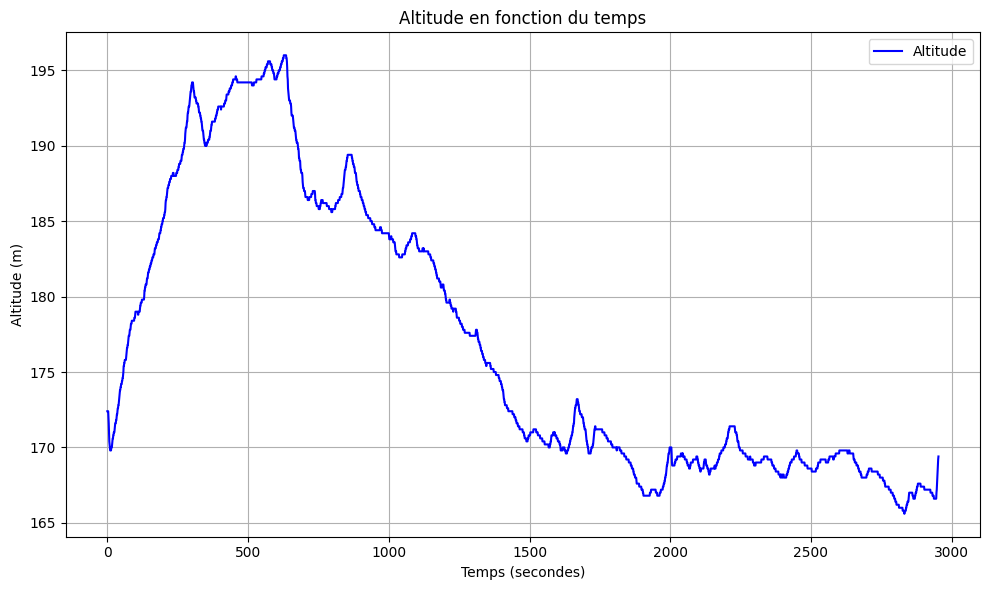

Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse e

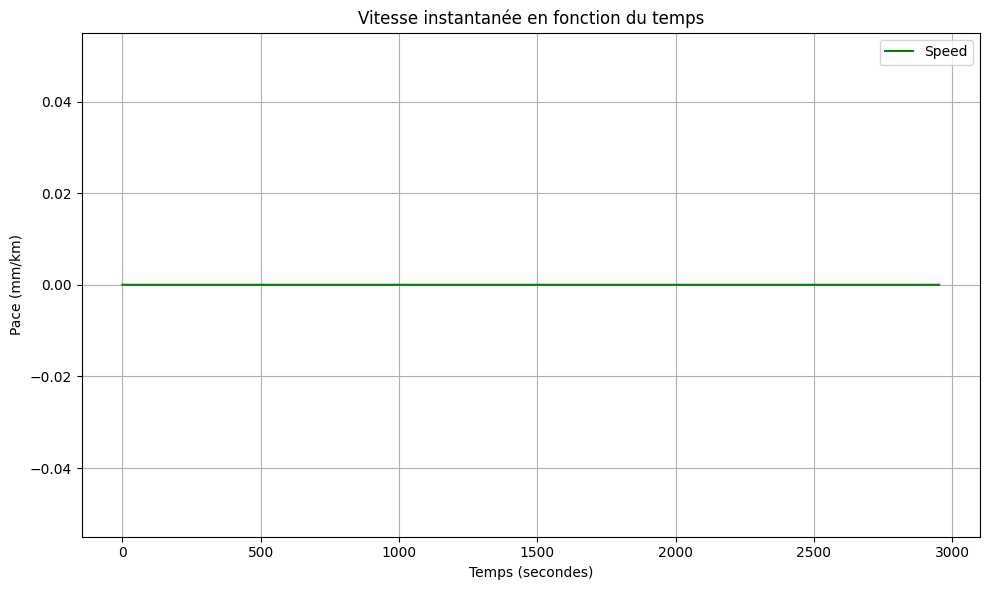

Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse extraite
Pas de vitesse e

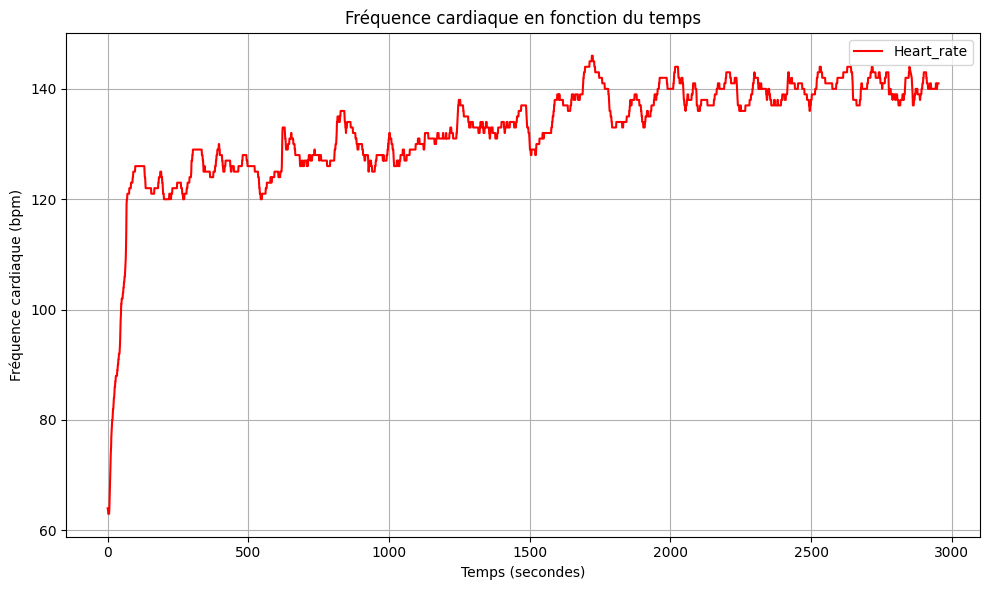

In [41]:
plot_data(tcx_files[0], "altitude")  # Afficher l'altitude
plot_data(tcx_files[0], "speed")  # Afficher la vitesse
plot_data(tcx_files[0], "heart_rate")  # Afficher la fréquence cardiaque

In [ ]:
for file in tcx_files:
  times, altitudes, speeds, heart_rates = extract_data_from_tcx(file)
  df = pd.DataFrame(speeds)
  print(df)


  

In [15]:
def extract_coordinates(Activite):
    # Extraire la latitude
    latitudes = []
    longitudes = []

    # Charger le fichier TCX
    tree = etree.parse(Activite)
    root = tree.getroot()

    # Parcourir tous les Trackpoints
    trackpoints = root.xpath("//tcx:Trackpoint", namespaces=ns)
    for trackpoint in trackpoints:
        latitude = trackpoint.xpath("tcx:Position/tcx:LatitudeDegrees", namespaces=ns)
        latitude = float(latitude[0].text) if latitude else None
        longitude = trackpoint.xpath("tcx:Position/tcx:LongitudeDegrees", namespaces=ns)
        longitude = float(longitude[0].text) if longitude else None
        if latitude is not None and longitude is not None:

            latitudes.append(latitude)
            longitudes.append(longitude)
    return latitudes, longitudes
    
    # Extraire la longitude


In [38]:
def plot_route(latitudes, longitudes):
    plt.figure(figsize=(10, 6))
    plt.plot(longitudes, latitudes, marker="o", markersize=1,linestyle="-", color="blue", linewidth=0.5)
    plt.title("Trajet GPS")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.axis('scaled')  # Conserve les proportions
    plt.grid(True)
    plt.show()

Traitement du fichier : activity_17482399352.tcx


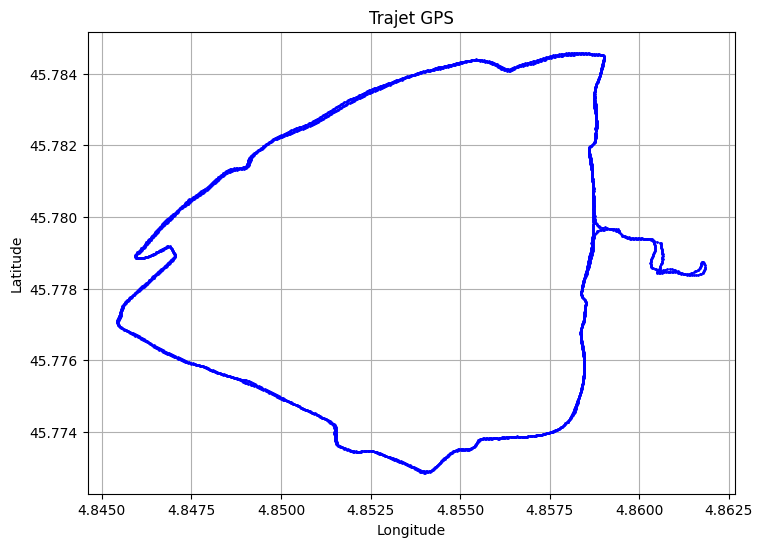

Traitement du fichier : activity_17490289008.tcx


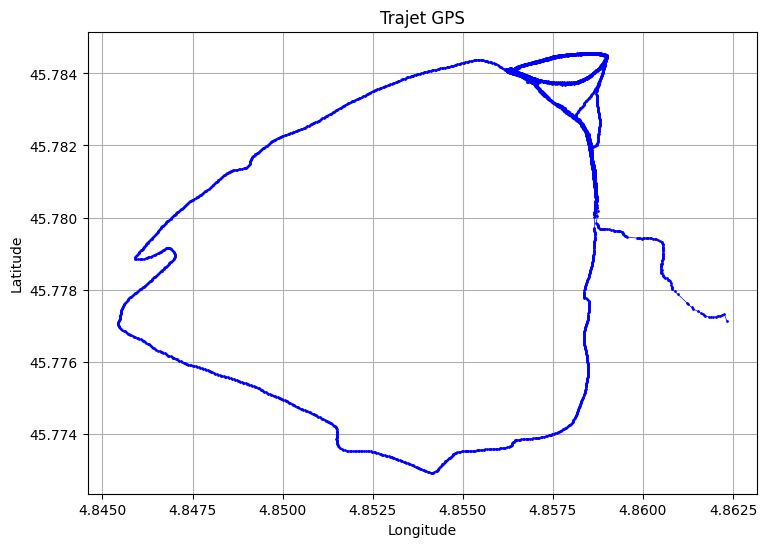

Traitement du fichier : activity_17507109341.tcx


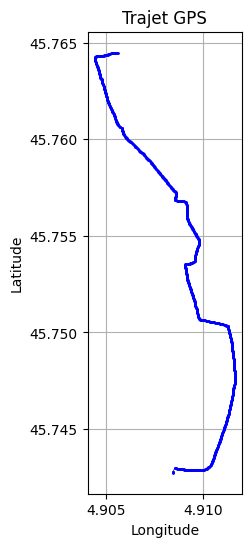

Traitement du fichier : activity_17512456424.tcx


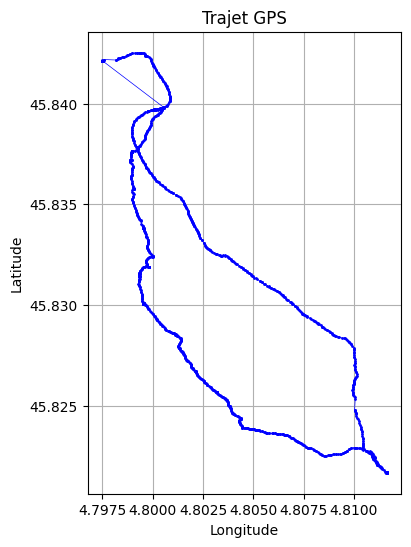

Traitement du fichier : activity_17522554619.tcx


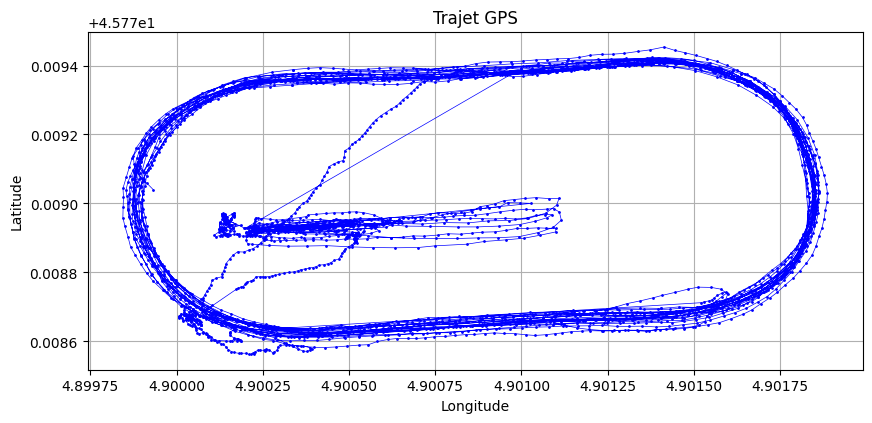

Traitement du fichier : activity_17535799744.tcx


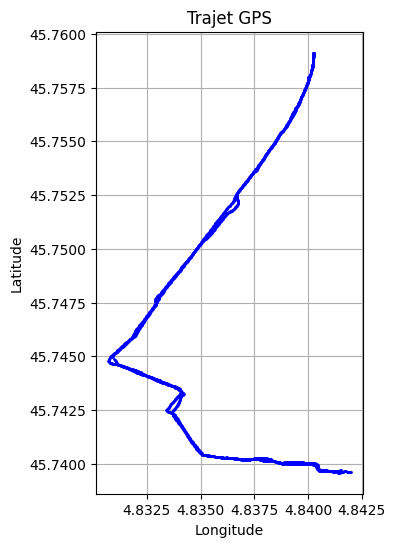

Traitement du fichier : activity_17550087476.tcx


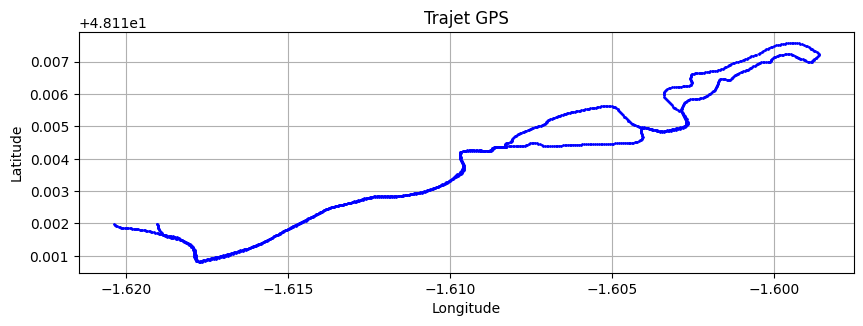

Traitement du fichier : activity_17556631216.tcx


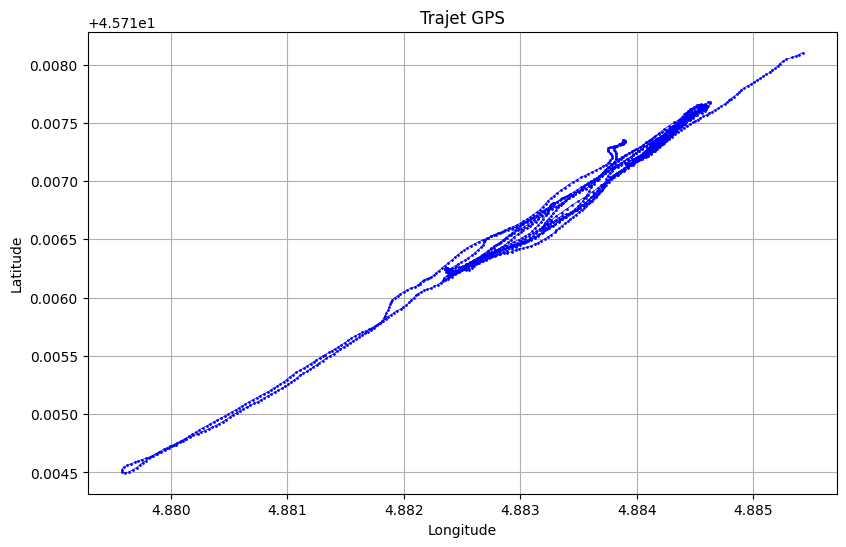

Traitement du fichier : activity_17556631939.tcx


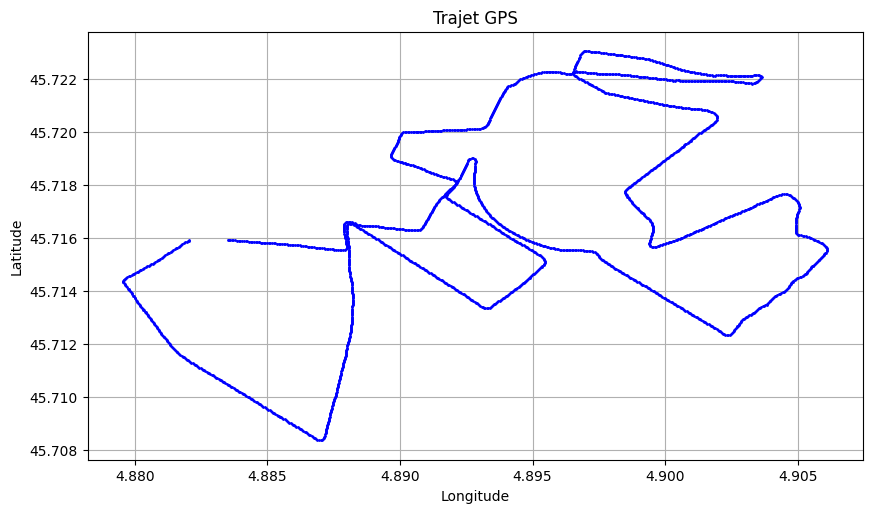

Traitement du fichier : activity_17649066143.tcx


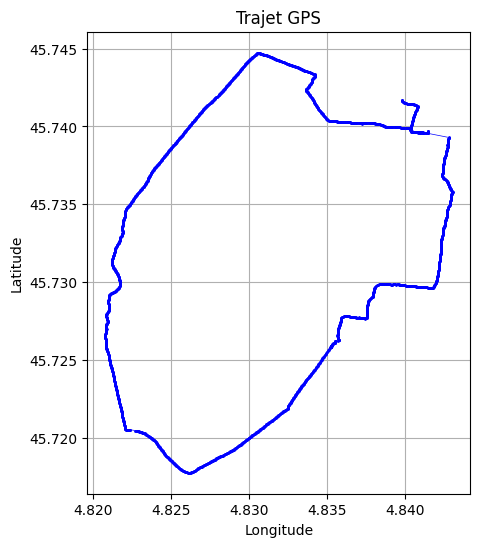

Traitement du fichier : activity_17665683882.tcx


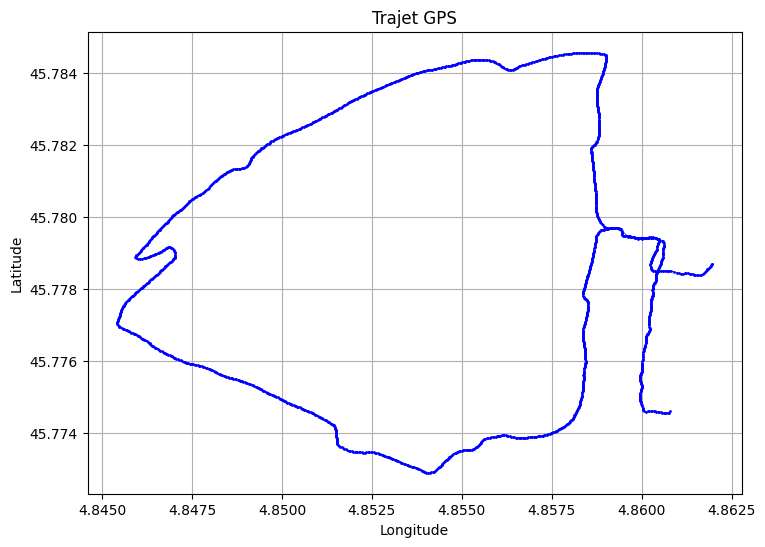

Traitement du fichier : activity_17686792876.tcx


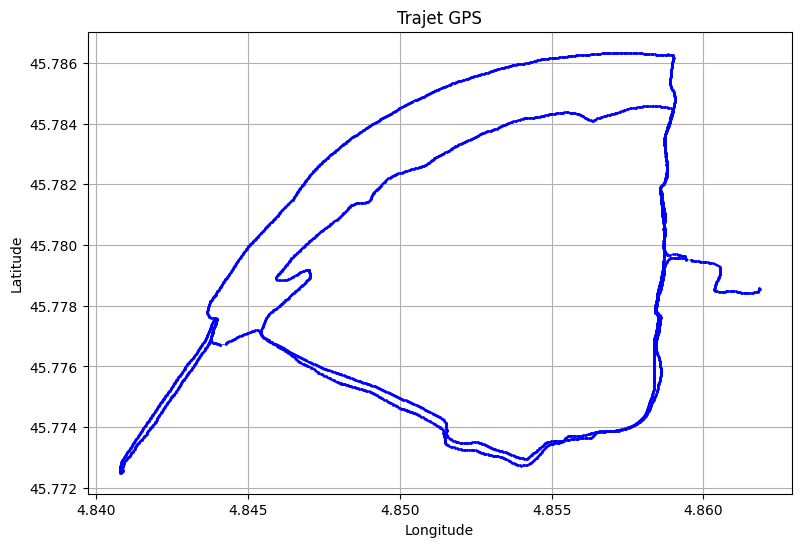

Traitement du fichier : activity_17700789297.tcx


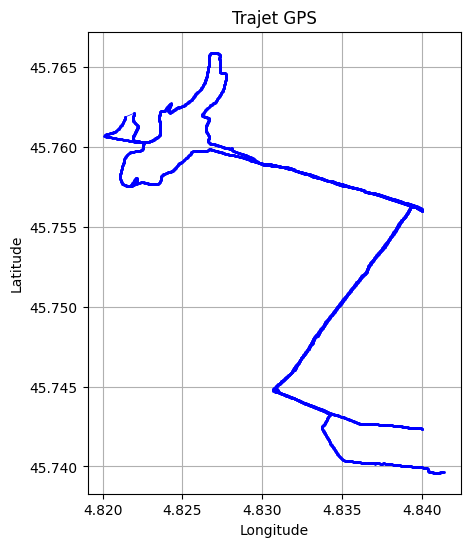

Traitement du fichier : activity_17715922870.tcx


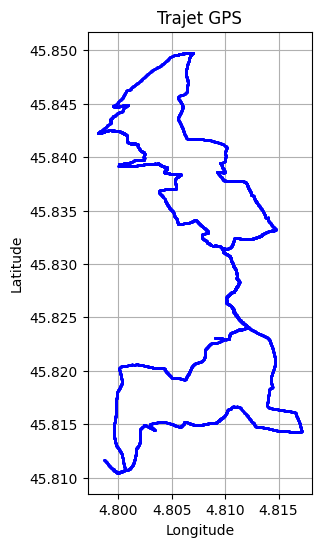

In [39]:

for file in tcx_files:
    print(f"Traitement du fichier : {file.name}")
         
    latitudes, longitudes = extract_coordinates(file) 

    # Tracer le trajet
    plot_route(latitudes, longitudes)

In [ ]:
#plot interactive route 

def plot_interactive_route(latitudes, longitudes):
    # Créer une carte centrée sur le premier point
    map_center = [latitudes[0], longitudes[0]]
    route_map = folium.Map(location=map_center, zoom_start=15)

    # Ajouter des points de passage
    points = list(zip(latitudes, longitudes))
    folium.PolyLine(points, color="blue", weight=5).add_to(route_map)

    # Ajouter des marqueurs pour le début et la fin du trajet
    folium.Marker(points[0], popup="Début", icon=folium.Icon(color="green")).add_to(route_map)
    folium.Marker(points[-1], popup="Fin", icon=folium.Icon(color="red")).add_to(route_map)

    # Sauvegarder la carte dans un fichier HTML
    route_map.save("route_map.html")
    print("Carte enregistrée : route_map.html")


In [ ]:

for file in tcx_files:
    print(f"Traitement du fichier : {file.name}")
         
    latitudes, longitudes = extract_coordinates(file)
    plot_interactive_route(latitudes, longitudes)

Traitement du fichier : activity_17482399352.tcx
Carte enregistrée : route_map.html
Traitement du fichier : activity_17490289008.tcx
Carte enregistrée : route_map.html
Traitement du fichier : activity_17507109341.tcx
Carte enregistrée : route_map.html
Traitement du fichier : activity_17512456424.tcx
Carte enregistrée : route_map.html
Traitement du fichier : activity_17522554619.tcx
Carte enregistrée : route_map.html
Traitement du fichier : activity_17535799744.tcx
Carte enregistrée : route_map.html
Traitement du fichier : activity_17550087476.tcx
Carte enregistrée : route_map.html
Traitement du fichier : activity_17556631216.tcx
Carte enregistrée : route_map.html
Traitement du fichier : activity_17556631939.tcx
Carte enregistrée : route_map.html
Traitement du fichier : activity_17649066143.tcx
Carte enregistrée : route_map.html
Traitement du fichier : activity_17665683882.tcx
Carte enregistrée : route_map.html
Traitement du fichier : activity_17686792876.tcx
Carte enregistrée : route_m

In [ ]:
IFrame("route_map.html", width=800, height=600)

In [ ]:
# Fonction pour extraire les coordonnées d'un fichier TCX
def extract_coordinates_from_tcx(file_path):
    latitudes = []
    longitudes = []

    # Charger le fichier TCX
    tree = etree.parse(file_path)
    root = tree.getroot()

    # Parcourir tous les Trackpoints
    trackpoints = root.xpath("//tcx:Trackpoint", namespaces=ns)
    for trackpoint in trackpoints:
        latitude = trackpoint.xpath("tcx:Position/tcx:LatitudeDegrees", namespaces=ns)
        longitude = trackpoint.xpath("tcx:Position/tcx:LongitudeDegrees", namespaces=ns)

        if latitude and longitude:
            latitudes.append(float(latitude[0].text))
            longitudes.append(float(longitude[0].text))

    return latitudes, longitudes




In [ ]:
all_coordinates = []  # Stocker toutes les coordonnées

for file in tcx_files:
    print(f"Traitement du fichier : {file.name}")
    latitudes, longitudes = extract_coordinates_from_tcx(file)
    all_coordinates.extend(zip(latitudes, longitudes))  # Ajouter les coordonnées comme tuples

Traitement du fichier : activity_17482399352.tcx
Traitement du fichier : activity_17490289008.tcx
Traitement du fichier : activity_17507109341.tcx
Traitement du fichier : activity_17512456424.tcx
Traitement du fichier : activity_17522554619.tcx
Traitement du fichier : activity_17535799744.tcx
Traitement du fichier : activity_17550087476.tcx
Traitement du fichier : activity_17556631216.tcx
Traitement du fichier : activity_17556631939.tcx
Traitement du fichier : activity_17649066143.tcx
Traitement du fichier : activity_17665683882.tcx
Traitement du fichier : activity_17686792876.tcx
Traitement du fichier : activity_17700789297.tcx
Traitement du fichier : activity_17715922870.tcx


In [ ]:
def plot_multiple_routes(all_coordinates):
    # Créer une carte centrée sur le premier point
    map_center = all_coordinates[0] if all_coordinates else [0, 0]
    route_map = folium.Map(location=map_center, zoom_start=13)

    # Ajouter chaque trajet à la carte
    folium.PolyLine(all_coordinates, color="blue", weight=2.5, opacity=0.7).add_to(route_map)

    # Sauvegarder la carte
    route_map.save("multiple_routes_map.html")
    print("Carte enregistrée : multiple_routes_map.html")
    return route_map

# Tracer toutes les routes superposées
plot_multiple_routes(all_coordinates)

Carte enregistrée : multiple_routes_map.html


In [ ]:
def plot_heatmap(all_coordinates):
    # Créer une carte centrée sur le premier point
    map_center = all_coordinates[0] if all_coordinates else [0, 0]
    heatmap = folium.Map(location=map_center, zoom_start=13)

    # Ajouter les données de la heatmap
    HeatMap(all_coordinates, radius=10, blur=15, max_zoom=1).add_to(heatmap)

    # Sauvegarder la carte
    heatmap.save("heatmap.html")
    print("Carte enregistrée : heatmap.html")
    return heatmap

# Créer une heatmap
plot_heatmap(all_coordinates)

Carte enregistrée : heatmap.html


In [109]:
@dataclass
class PointGPS:
    time: float
    latitude: float
    longitude: float
    altitude: float
    distance: float
    heartRate: int
    speed: float
    runCadence: int
    watts: int

In [110]:
@dataclass
class Lap:
    start_time: str
    total_time: float
    distance: float
    max_speed: float
    calories: int
    avg_hr: int
    max_hr: int
    intensity: str
    trigger: str
    points: list[PointGPS]


In [129]:
#root : C'est l'objet racine de l'arbre XML, obtenu en analysant le fichier avec lxml (via etree.parse() ou similaire). Il représente la totalité du document XML.
#xpath() : méthode de lxml qui permet de naviguer dans la structure XML en utilisant des requêtes XPath pour sélectionner des parties spécifiques d'un document XML.
#"//tcx:Activity" : requête XPath pour trouver toutes les balises <Activity> dans le document, avec le préfixe tcx.
#namespaces=ns :associe le préfixe tcx à l'espace de noms spécifié dans le dictionnaire ns, afin que lxml puisse reconnaître les balises <Activity> qui appartiennent à cet espace de noms.
# requête : root.xpath("//tcx:Activity", namespaces=ns)
#Le double slash // signifie "sélectionne tous les nœuds correspondants, quel que soit leur emplacement dans le document".
#Cela permet de rechercher les balises <Activity> où qu'elles se trouvent, à n'importe quel niveau de la hiérarchie XML.



# Parcourt chaque fichier TCX
def Data_from_tcx(file):
    points = []  # Liste pour stocker les données
    laps = []  # Liste pour stocker les données
    print(f"Traitement du fichier : {file.name}")

    # Lire le fichier avec lxml
    with open(file, 'rb') as f:
        tree = etree.parse(f)

        # Exemple : récupérer les activités
        activities = tree.xpath("//tcx:Activity", namespaces=ns)
        for activity in activities:
            sport = activity.attrib.get("Sport", "N/A")
            print(f"Sport : {sport}")

            activity_id = activity.find(".//tcx:Id", namespaces=ns)
            print(f"Id de l'activité : {activity_id.text if activity_id is not None else 'N/A'}")

        
            laps = activity.xpath(".//tcx:Lap", namespaces=ns)
            #laps = activity.findall(".//tcx:Lap", namespaces=ns)
            for lap in laps:
                #start_time = lap.attrib.get("StartTime","N/A")
                start_time = lap.get("StartTime", "N/A")
                trackpoints = activity.findall(".//tcx:Trackpoint", namespaces=ns)
                total_time = lap.find(".//tcx:TotalTimeSeconds", namespaces=ns)
                distance = lap.find(".//tcx:DistanceMeters", namespaces=ns)
                max_speed = lap.find(".//tcx:MaximumSpeed", namespaces=ns)
                calories = lap.find(".//tcx:Calories", namespaces=ns)
                avg_hr = lap.find(".//tcx:AverageHeartRateBpm/tcx:Value", namespaces=ns)
                max_hr = lap.find(".//tcx:MaximumHeartRateBpm/tcx:Value", namespaces=ns)
                intensity = lap.find(".//tcx:Intensity", namespaces=ns)
                trigger = lap.find(".//tcx:TriggerMethod", namespaces=ns)

                # Vérifiez que les éléments ne sont pas None avant d'accéder à leur texte
                start_time_text = start_time if start_time is not None else 'N/A'
                total_time_text = float(total_time.text) if total_time is not None and total_time.text else 0.0
                distance_text = float(distance.text) if distance is not None and distance.text else 0.0
                max_speed_text = float(max_speed.text) if max_speed is not None and max_speed.text else 0.0
                calories_text = int(calories.text) if calories is not None and calories.text else 0
                avg_hr_text = int(avg_hr.text) if avg_hr is not None and avg_hr.text else 0
                max_hr_text = int(max_hr.text) if max_hr is not None and max_hr.text else 0
                intensity_text = intensity.text if intensity is not None and intensity.text else 'N/A'
                trigger_text = trigger.text if trigger is not None and trigger.text else 'N/A'
                
                #print(f"Lap StartTime: {start_time}")
                #print(f"Total Time (s): {total_time.text if total_time is not None else 'N/A'}")
                #print(f"Distance (m): {distance.text if distance is not None else 'N/A'}")
                #print(f"Calories: {calories.text if calories is not None else 'N/A'}")
                #print(f"Avg Heart Rate: {avg_hr.text if avg_hr is not None else 'N/A'}")
                #print(f"Max Heart Rate: {max_hr.text if max_hr is not None else 'N/A'}")

                trackpoints = activity.findall(".//tcx:Trackpoint", namespaces=ns)
                for trackpoint in trackpoints:
                    time = trackpoint.find(".//tcx:Time", namespaces=ns)
                    lat = trackpoint.find(".//tcx:Position/tcx:LatitudeDegrees", namespaces=ns)
                    lon = trackpoint.find(".//tcx:Position/tcx:LongitudeDegrees", namespaces=ns)
                    altitude = trackpoint.find(".//tcx:AltitudeMeters", namespaces=ns)
                    distance = trackpoint.find(".//tcx:DistanceMeters", namespaces=ns)
                    heart_rate = trackpoint.find(".//tcx:HeartRateBpm/tcx:Value", namespaces=ns)


                    # Vérifiez que les éléments ne sont pas None avant d'accéder à leur texte
                    time_text = time.text if time is not None and time.text else 'N/A'
                    lat_text = float(lat.text) if lat is not None and lat.text else 0.0
                    lon_text = float(lon.text) if lon is not None and lon.text else 0.0
                    altitude_text = float(altitude.text) if altitude is not None and altitude.text else 0.0
                    distance_text = float(distance.text) if distance is not None and distance.text else 0.0
                    heart_rate = int(heart_rate.text) if heart_rate is not None and heart_rate.text else 0
                                      
                    extensions = trackpoint.findall(".//tcx:Extensions", namespaces=ns)
                    for extension in extensions:
                        speed = extension.find(".//ns3:Speed", namespaces=ns)
                        runCadence = extension.find(".//ns3:RunCadence", namespaces=ns)
                        watts = extension.find(".//ns3:Watts", namespaces=ns)
                        
                        speed_text = float(speed.text) if speed is not None and speed.text else 0.0
                        runCadence_text = int(runCadence.text) if runCadence is not None and runCadence.text else 0
                        watts_text = int(watts.text) if watts is not None and watts.text else 0
              

                    currentPoint = PointGPS(
                        time=time_text,
                        latitude=lat_text,
                        longitude=lon_text,
                        altitude=altitude_text,
                        distance=distance_text,
                        heartRate=heart_rate,
                        speed=speed_text,
                        runCadence=runCadence_text,
                        watts=watts_text
                    )
                    points.append(currentPoint)

                currentLap = Lap(
                    start_time=start_time_text,
                    total_time=total_time_text,
                    distance=distance_text,
                    max_speed=max_speed_text,
                    calories=calories_text,
                    avg_hr=avg_hr_text,
                    max_hr=max_hr_text,
                    intensity=intensity_text,
                    trigger=trigger_text,
                    points=points
                )
                laps.append(currentLap)
                points = []  # Réinitialiser la liste des points pour le prochain tour
                


                
    #return points
    return laps
    #return activities

In [ ]:
points = Data_from_tcx(tcx_files[0])  # Remplacez par le chemin de votre fichier GPX)

# Exemple : afficher les points avec leur numéro
for index, p in enumerate(points, start=1):
    print(f"Point {index}: {p}")

In [130]:
laps = Data_from_tcx(tcx_files[0])  # Remplacez par le chemin de votre fichier GPX)

# Exemple d'affichage
for i, lap in enumerate(laps):
    print(f"Lap {i+1}: {len(lap.points)} points, distance: {lap.distance:.2f} m, avg HR: {lap.avg_hr}")

"""
# Exemple : afficher les points avec leur numéro
for index, lap in enumerate(laps, start=1):
    print(f"Lap {index}: {lap.start_time}, {lap.total_time}, {lap.distance}, {lap.max_speed}, {lap.calories}, {lap.avg_hr}, {lap.max_hr}, {lap.intensity}, {lap.trigger}")
    for point in lap.points:
        print(f"  Point: {point.time}, {point.latitude}, {point.longitude}, {point.altitude}, {point.distance}, {point.heartRate}, {point.speed}, {point.runCadence}, {point.watts}")
"""

Traitement du fichier : activity_17482399352.tcx
Sport : Running
Id de l'activité : 2024-11-07T17:34:46.000Z


AttributeError: 'Lap' object has no attribute 'get'

In [ ]:
import math

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # rayon de la Terre en mètres
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    d_phi = math.radians(lat2 - lat1)
    d_lambda = math.radians(lon2 - lon1)

    a = math.sin(d_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(d_lambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c  # en mètres

In [ ]:
def stats_parcours(points):
    total_distance = sum(p.distance_from_prev for p in points)
    total_time = (points[-1].time - points[0].time).total_seconds()
    vitesse_moy = (total_distance / total_time * 3.6) if total_time > 0 else 0  # en km/h
    print(f"Distance totale : {total_distance:.1f} m")
    print(f"Durée totale    : {total_time/60:.1f} min")
    print(f"Vitesse moyenne : {vitesse_moy:.2f} km/h")

In [ ]:
def plot_vitesse_altitude(points):
    temps = [(p.time - points[0].time).total_seconds() / 60 for p in points]  # en minutes
    vitesses = [p.vitesse_kmh for p in points]
    altitudes = [p.elevation for p in points]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel("Temps (minutes)")
    ax1.set_ylabel("Vitesse (km/h)", color="blue")
    ax1.plot(temps, vitesses, color="blue", label="Vitesse")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Altitude (m)", color="green")
    ax2.plot(temps, altitudes, color="green", linestyle="--", label="Altitude")
    ax2.tick_params(axis='y', labelcolor="green")

    plt.title("Évolution de la vitesse et de l'altitude")
    plt.grid(True)
    plt.show()


In [ ]:
fichier = "ton_fichier.gpx"
points = Data_from_tcx(fichier)

stats_parcours(points)
plot_vitesse_altitude(points)
